In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
import anndata2ri

In [2]:
import warnings
anndata2ri.activate()
%load_ext rpy2.ipython

sc.settings.verbosity = 0
warnings.filterwarnings("ignore")

C:\Users\yjyang027\Miniconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
def Xct_DB(specis = 'Human'):
    if specis == 'mouse':
        LR = pd.read_csv('https://raw.githubusercontent.com/yjgeno/Ligand-Receptor-Pairs/master/Mouse/Mouse-2020-Jin-LR-pairs.csv')
    else:
        LR = pd.read_csv('https://raw.githubusercontent.com/yjgeno/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
    ligands = LR['ligand'].str.split('_', expand=True)
    ligands.columns = ['lig_A', 'lig_B']
    receptors = LR['receptor'].str.split('_', expand=True)
    receptors.columns = ['rec_A', 'rec_B', 'rec_C']
    LRs = pd.concat([LR[['pathway_name']], ligands, receptors], axis=1)
    del LR
    
    return LRs

In [4]:
LRs = Xct_DB()
LRs.head()

,pathway_name,lig_A,lig_B,rec_A,rec_B,rec_C
0,TGFb,TGFB1,None,TGFbR1,R2,None
1,TGFb,TGFB2,None,TGFbR1,R2,None
2,TGFb,TGFB3,None,TGFbR1,R2,None
3,TGFb,TGFB1,None,ACVR1B,TGFbR2,None
4,TGFb,TGFB1,None,ACVR1C,TGFbR2,None


In [5]:
%%R

library(Seurat)

R[write to console]: Attaching SeuratObject



In [6]:
%%R

load(url("https://ndownloader.figshare.com/files/25950872")) 
data.input = data_humanSkin$data # input normalized data matrix
meta = data_humanSkin$meta # a dataframe of cell metadata

In [7]:
%%R -o labels

cell.use = rownames(meta)[meta$condition == "LS"] # extract the cell names from disease data
data.input = data.input[, cell.use]
meta = meta[cell.use, ]
labels <- as.vector(meta$labels)
#unique(meta$labels) # check the cell labels

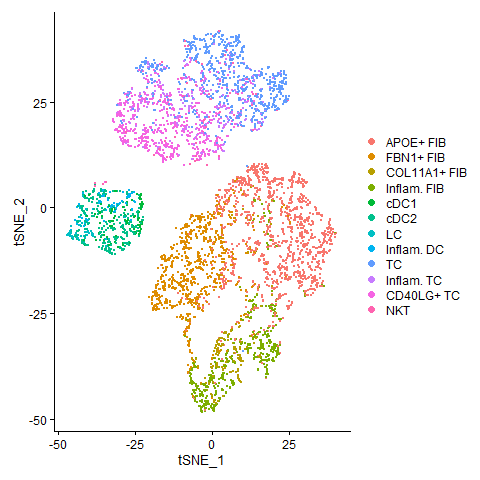

In [8]:
%%R 

set.seed(42)
LS <- CreateSeuratObject(data.input, project = 'LS', meta.data = meta)
Idents(LS) <- LS$labels
LS <- FindVariableFeatures(LS, nfeatures=2500, verbose = F)
LS <- ScaleData(LS, verbose = F) 
LS <- RunPCA(LS, verbose = F)
LS <- RunTSNE(LS)
TSNEPlot(LS)
#VariableFeaturePlot(object = LS)

R[write to console]: When using repel, set xnudge and ynudge to 0 for optimal results



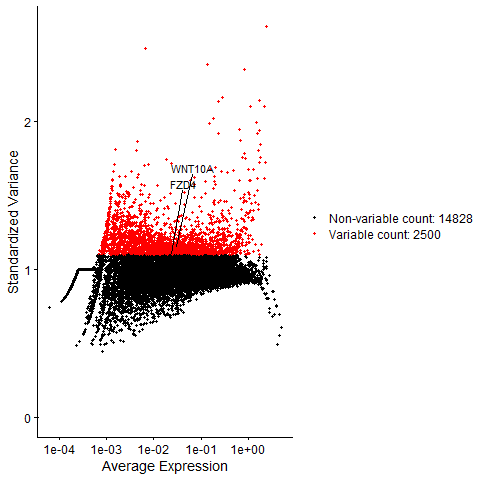

In [9]:
%%R
top <- head(VariableFeatures(LS), 50)
#png('HVG_examples.png', width = 4000, height = 4000, res = 300)
plot1 <- VariableFeaturePlot(object = LS)
LabelPoints(plot = plot1, points = c('WNT10A', 'FZD4'), repel = TRUE, xnudge=0.3, ynudge=0.5, max.overlaps = Inf)

#CombinePlots(plots = list(plot1, plot2))
#dev.off()

In [10]:
%%R -o counts -o HVGenes -o Genes -o Cells

counts <- GetAssayData(LS, slot = 'data')
Genes <- rownames(counts)
HVGenes <- rownames(GetAssayData(LS, slot = 'scale.data'))
Cells <- colnames(counts)


In [11]:
from scipy.sparse import csr_matrix
counts = csr_matrix.toarray(counts)

In [12]:
counts.shape

(17328, 5011)

### log data

In [13]:
ada = AnnData(counts.T)
ada.obs['barcodes'] = np.array(Cells)
ada.obs['ident'] = np.array(labels)
ada.var['gene_symbols'] = np.array(Genes)

ada.obs_names = ada.obs['barcodes']
ada.var_names = ada.var['gene_symbols']
#print(ada.isview)
ada = ada[:, ada.var_names.isin(HVGenes)].copy() #Not ArrayView

ada

AnnData object with n_obs × n_vars = 5011 × 2500
    obs: 'barcodes', 'ident'
    var: 'gene_symbols'

### Xct

In [14]:
ada.obs['ident'].unique()

array(['Inflam. FIB', 'FBN1+ FIB', 'APOE+ FIB', 'COL11A1+ FIB', 'cDC2',
       'LC', 'Inflam. DC', 'cDC1', 'CD40LG+ TC', 'Inflam. TC', 'TC',
       'NKT'], dtype=object)

In [15]:
CellA = 'Inflam. FIB'
CellB = 'Inflam. DC'

In [16]:
def Xct_init(ada, CellA, CellB, DB, verbose = False):
    result = {}
    AB = ada[ada.obs['ident'].isin([CellA, CellB]), :]
    A = AB[AB.obs['ident'] == CellA, :].copy()
    B = AB[AB.obs['ident'] == CellB, :].copy()
    
    for lig in ['lig_A', 'lig_B']:
        l_exp = []
        l_var = []
        for l in DB[lig]:
            if l not in np.array(A.var_names):
                l_exp.append(np.nan)
                l_var.append(np.nan)
            else:
                l_exp.append(np.mean(A[:, A.var_names.isin([l])].X))
                l_var.append(np.var(A[:, A.var_names.isin([l])].X))
        result['{}_exp'.format(lig)] = l_exp
        result['{}_var'.format(lig)] = l_var
    
    for rec in ['rec_A', 'rec_B', 'rec_C']:
        r_exp = []
        r_var = []
        for r in DB[rec]:
            if r not in np.array(B.var_names):
                r_exp.append(np.nan)
                r_var.append(np.nan)
            else:
                r_exp.append(np.mean(B[:, B.var_names.isin([r])].X)) #mean expression of L and R
                r_var.append(np.var(B[:, B.var_names.isin([r])].X))
        result['{}_exp'.format(rec)] = r_exp
        result['{}_var'.format(rec)] = r_var
    #print(result.keys())

    LRs_Xct = DB.copy() 
    LRs_Xct = pd.concat([LRs_Xct, pd.DataFrame.from_dict(result)], axis=1)
    mask1 = np.invert(LRs_Xct[['lig_A_exp', 'rec_A_exp']].isna().any(axis=1)) # remove NA
    mask2 = (LRs_Xct['lig_A_exp'] > 0) & (LRs_Xct['rec_A_exp'] > 0) # remove 0 for original LR
    LRs_Xct = LRs_Xct[mask1 & mask2]
    if verbose:
        print('Selected {} LR pairs'.format(LRs_Xct.shape[0]))

    return LRs_Xct
    

In [17]:
def Xct_pmt(ada, CellA, CellB, Ref, verbose = False):
    result = {}
    AB = ada[ada.obs['ident'].isin([CellA, CellB]), :].copy()
    
    #np.random.seed(42)
    labels_pmt = np.random.permutation(AB.obs['ident'])
    AB.obs['ident'] = labels_pmt         
    A = AB[AB.obs['ident'] == CellA, :]
    B = AB[AB.obs['ident'] == CellB, :]
    
    if verbose:
        print('Cell A and B permutated')       
       #print(AB.obs['ident'][:10].unique(), AB.obs['ident'][-10:].unique()) #check
        print('# of {}: {}; # of {}: {}'.format(CellA, A.shape[0], CellB, B.shape[0]))
   
    for lig in ['lig_A', 'lig_B']:
        l_exp = []
        l_var = []
        for l in Ref[lig]:
            if l not in np.array(A.var_names):
                l_exp.append(0)
                l_var.append(0)
            else:
                l_exp.append(np.mean(A[:, A.var_names.isin([l])].X))
                l_var.append(np.var(A[:, A.var_names.isin([l])].X))
        result['{}_exp'.format(lig)] = l_exp
        result['{}_var'.format(lig)] = l_var
    
    for rec in ['rec_A', 'rec_B', 'rec_C']:
        r_exp = []
        r_var = []
        for r in Ref[rec]:
            if r not in np.array(B.var_names):
                r_exp.append(0)
                r_var.append(0)
            else:
                r_exp.append(np.mean(B[:, B.var_names.isin([r])].X)) #mean expression of L and R
                r_var.append(np.var(B[:, B.var_names.isin([r])].X))
        result['{}_exp'.format(rec)] = r_exp
        result['{}_var'.format(rec)] = r_var
    
    #print(result.keys()) 
    result = pd.DataFrame.from_dict(result)
    assert len(result) == len(Ref)
    
    return result
  

In [18]:
def Xct_Score(df, method = 0):
    lig = ['lig_A_exp', 'lig_B_exp', 'lig_A_var', 'lig_B_var']
    rec = ['rec_A_exp', 'rec_B_exp', 'rec_C_exp', 'rec_A_var', 'rec_B_var', 'rec_C_var']
    if (set(lig) | set(rec)).issubset(df.columns):
        exp_R = np.array(df[rec[:3]].max(axis=1)) #mean for R   
        exp_L = np.array(df[lig[:2]].max(axis=1))    
        if method == 0:
            S = exp_L * exp_R        
        elif method == 1:
            var_R = np.array(df[rec[3:]].max(axis=1)) #var for R
            var_L = np.array(df[lig[2:]].max(axis=1))
            S = (exp_L**2 + var_L)*(exp_R**2 + var_R)
        
        return S.astype(float)
    
    else:
        print('Error: column names')

In [19]:
def Xct_Scores(ada, CellA, CellB, LRs_ref, s = 0, n = 100): #s: score method, permute n times
    scores = []
    for _ in range(n):
        LRs_pmt = Xct_pmt(ada, CellA, CellB, Ref = LRs_ref, verbose = False)
        scores.append(Xct_Score(df = LRs_pmt, method = s))

    assert all(len(i) == len(LRs_ref) for i in scores) #check if equal len of ref LR pairs
    return np.array(scores).T  #transpose for further looping

In [20]:
def Xct_PmtTest(orig_score, scores, p = 0.05):
    enriched_i = []
    pvals = []
    counts = []
    for i, dist in enumerate(scores):
        count = sum(orig_score[i] > value for value in dist)
        pval = 1- count/len(dist)
        pvals.append(pval)
        counts.append(count)
        
        if pval < p:
            enriched_i.append(i)           
    
    return enriched_i, pvals, counts

In [21]:
def vis(orig_Scores, Scores, i, LRs, density = False): #index i in LRs_Selected
    print('LR pair: {} - {}'.format(LRs.iloc[i]['lig_A'], LRs.iloc[i]['rec_A']))
    plt.hist(Scores[i], density = density)
    plt.axvline(x = orig_Scores[i], color = 'r')
    plt.show()

### test

In [22]:
LRs_ref = Xct_init(ada, CellA, CellB, DB = LRs, verbose = True)
LRs_ref

Selected 6 LR pairs


,pathway_name,lig_A,lig_B,rec_A,rec_B,rec_C,lig_A_exp,lig_A_var,lig_B_exp,lig_B_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
645,CCL,CCL19,None,CCR7,None,None,1.7382643,5.539186,NaN,NaN,1.6885129,1.9415792,NaN,NaN,NaN,NaN
646,CCL,CCL21,None,CCR7,None,None,0.05082678,0.100430116,NaN,NaN,1.6885129,1.9415792,NaN,NaN,NaN,NaN
711,CXCL,CXCL12,None,CXCR4,None,None,1.4257646,2.7257175,NaN,NaN,1.3560512,1.5149305,NaN,NaN,NaN,NaN
806,TNF,TNF,None,TNFRSF1B,None,None,0.0031172754,0.004693508,NaN,NaN,0.3725189,0.68993086,NaN,NaN,NaN,NaN
825,CD137,TNFSF9,None,TNFRSF9,None,None,0.0058077816,0.009628484,NaN,NaN,0.35003668,0.49893814,NaN,NaN,NaN,NaN
1991,SEMA6,SEMA6A,None,PLXNA4,None,None,0.0110205,0.029280404,NaN,NaN,0.054223344,0.12551613,NaN,NaN,NaN,NaN


In [23]:
LRs_pmt = Xct_pmt(ada, CellA, CellB, Ref = LRs_ref, verbose = True)
LRs_pmt

Cell A and B permutated
# of Inflam. FIB: 484; # of Inflam. DC: 81


,lig_A_exp,lig_A_var,lig_B_exp,lig_B_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
0,1.5055077,5.039547,0,0,0.3389184,0.7613056,0,0,0,0
1,0.047310486,0.094790824,0,0,0.3389184,0.7613056,0,0,0,0
2,1.2496935,2.5988488,0,0,0.15790866,0.24444097,0,0,0,0
3,0.052594114,0.12927745,0,0,0.027554624,0.030896384,0,0,0,0
4,0.010860663,0.021901555,0,0,0.04880818,0.09410947,0,0,0,0
5,0.0110205,0.029280405,0,0,0.019502634,0.030428218,0,0,0,0


In [24]:
orig_Scores = Xct_Score(df = LRs_ref)
orig_Scores

array([2.93508177e+00, 8.58216756e-02, 1.93340975e+00, 1.16124400e-03,
       2.03293659e-03, 5.97568371e-04])

In [25]:
pmt_Scores = Xct_Score(df = LRs_pmt)
pmt_Scores

array([5.10244245e-01, 1.60343938e-02, 1.97337432e-01, 1.44921103e-03,
       5.30089188e-04, 2.14928784e-04])

In [26]:
np.random.seed(1)
Scores = Xct_Scores(ada, CellA, CellB, LRs_ref = LRs_ref, n=10)
Scores.shape

(6, 10)

In [27]:
Scores

array([[5.26942177e-01, 3.57124758e-01, 4.13094475e-01, 5.16568403e-01,
        2.84763627e-01, 3.21352042e-01, 6.40022021e-01, 4.70018426e-01,
        4.24989781e-01, 3.92750784e-01],
       [1.21274368e-02, 8.52903692e-03, 1.38949302e-02, 1.56546696e-02,
        6.80694076e-03, 5.56845371e-03, 1.68556452e-02, 1.33338076e-02,
        1.14143342e-02, 1.18494084e-02],
       [2.28701317e-01, 2.86905216e-01, 2.31329461e-01, 1.55073815e-01,
        2.94661115e-01, 2.08001442e-01, 4.37621872e-01, 2.48324707e-01,
        3.46130618e-01, 2.11194304e-01],
       [1.04591676e-02, 8.35206892e-03, 8.77347635e-03, 9.84919838e-04,
        1.13287122e-02, 9.44328487e-03, 2.67953386e-03, 4.28316695e-03,
        7.12964844e-03, 5.77134609e-03],
       [1.04311230e-03, 1.88844605e-04, 8.63256418e-04, 7.37648224e-04,
        8.03690453e-04, 4.41946727e-04, 4.03230587e-04, 3.96103248e-04,
        5.91747666e-04, 1.29207631e-04],
       [2.41987297e-04, 1.11917045e-03, 1.02573330e-03, 5.37666644e-04,
   

In [28]:
enriched, pvals, counts = Xct_PmtTest(orig_Scores, Scores)
enriched

[0, 1, 2, 4]

In [29]:
counts

[10, 10, 10, 1, 10, 4]

In [30]:
LRs_Enriched = LRs_ref.iloc[enriched, :]
LRs_Enriched

,pathway_name,lig_A,lig_B,rec_A,rec_B,rec_C,lig_A_exp,lig_A_var,lig_B_exp,lig_B_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
645,CCL,CCL19,None,CCR7,None,None,1.7382643,5.539186,NaN,NaN,1.6885129,1.9415792,NaN,NaN,NaN,NaN
646,CCL,CCL21,None,CCR7,None,None,0.05082678,0.100430116,NaN,NaN,1.6885129,1.9415792,NaN,NaN,NaN,NaN
711,CXCL,CXCL12,None,CXCR4,None,None,1.4257646,2.7257175,NaN,NaN,1.3560512,1.5149305,NaN,NaN,NaN,NaN
825,CD137,TNFSF9,None,TNFRSF9,None,None,0.0058077816,0.009628484,NaN,NaN,0.35003668,0.49893814,NaN,NaN,NaN,NaN


LR pair: CCL19 - CCR7


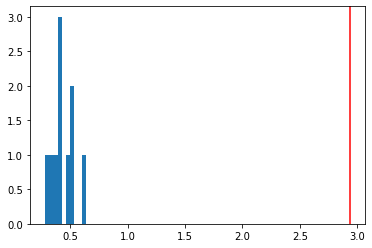

In [31]:
vis(orig_Scores, Scores, 0, LRs = LRs_ref)

### method2

In [32]:
orig_Scores2 = Xct_Score(df = LRs_ref, method=1)
orig_Scores2

array([4.10287167e+01, 4.93708070e-01, 1.59591570e+01, 3.89756859e-03,
       6.00471665e-03, 3.77685359e-03])

In [33]:
np.random.seed(4)
Scores2 = Xct_Scores(ada, CellA, CellB, LRs_ref = LRs_ref, s = 1, n=10)
Scores2.shape

(6, 10)

In [34]:
Scores2

array([[7.99561214e+00, 4.94968710e+00, 3.62927942e+00, 2.56021628e+00,
        5.06667825e+00, 3.75824848e+00, 6.49270873e+00, 5.05144934e+00,
        6.08240931e+00, 6.23727422e+00],
       [8.91123566e-02, 6.39697537e-02, 4.17997126e-02, 3.47830269e-02,
        5.09573679e-02, 5.31666092e-02, 6.97780821e-02, 6.95082744e-02,
        8.23157094e-02, 6.66340287e-02],
       [1.66097983e+00, 1.86650155e+00, 9.90624763e-01, 1.15417827e+00,
        1.27216687e+00, 1.94405530e+00, 2.49357465e+00, 1.76187695e+00,
        1.72670307e+00, 1.33963569e+00],
       [3.48339114e-02, 2.71246111e-02, 3.56728535e-03, 2.09800592e-02,
        2.77970562e-02, 3.45644619e-02, 7.50459070e-02, 2.41742091e-02,
        2.08776144e-02, 3.77764904e-02],
       [8.47717478e-04, 1.22584804e-03, 2.95784601e-03, 1.10825957e-03,
        1.13172189e-03, 9.28306256e-04, 3.70065959e-03, 2.03703728e-03,
        2.15252974e-03, 0.00000000e+00],
       [3.01150942e-03, 3.52488255e-03, 7.51360919e-03, 2.78488835e-03,
   

In [35]:
enriched, pvals, counts = Xct_PmtTest(orig_Scores2, Scores2)
enriched

[0, 1, 2, 4]

In [36]:
LRs_Enriched = LRs_ref.iloc[enriched, :]
LRs_Enriched

,pathway_name,lig_A,lig_B,rec_A,rec_B,rec_C,lig_A_exp,lig_A_var,lig_B_exp,lig_B_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
645,CCL,CCL19,None,CCR7,None,None,1.7382643,5.539186,NaN,NaN,1.6885129,1.9415792,NaN,NaN,NaN,NaN
646,CCL,CCL21,None,CCR7,None,None,0.05082678,0.100430116,NaN,NaN,1.6885129,1.9415792,NaN,NaN,NaN,NaN
711,CXCL,CXCL12,None,CXCR4,None,None,1.4257646,2.7257175,NaN,NaN,1.3560512,1.5149305,NaN,NaN,NaN,NaN
825,CD137,TNFSF9,None,TNFRSF9,None,None,0.0058077816,0.009628484,NaN,NaN,0.35003668,0.49893814,NaN,NaN,NaN,NaN


In [37]:
counts

[10, 10, 10, 1, 10, 7]

LR pair: CCL19 - CCR7


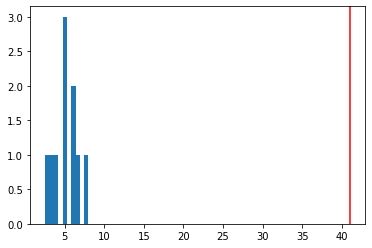

In [38]:
vis(orig_Scores2, Scores2, 0, LRs = LRs_ref)